In [1]:
import pathlib

In [2]:
%matplotlib inline
from cartopy import crs as ccrs
from matplotlib import pyplot as plt

In [3]:
from datetime import datetime, timedelta

from dateutil.relativedelta import relativedelta

In [4]:
import numpy as np
import pandas as pd
import xarray as xr

In [5]:
from dask.diagnostics import ProgressBar

In [6]:
from ICU_Water_Watch import MSWEP, domains, geo, plot, utils

In [7]:
dpath = "/media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge"
dpath_shapes = "/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles"
domain_name = "SP"
nbdays_agg = 90
lag_to_realtime = 2
varname = "precipitation"
fig_kwargs = dict(dpi=200, bbox_inches="tight", facecolor="w")
clim_start = 1991
clim_stop = 2020

In [8]:
dpath = pathlib.Path(dpath).joinpath(f"{domain_name}/outputs")
dpath_shapes = pathlib.Path(dpath_shapes)

In [9]:
today = datetime.utcnow().date()
date_stop = today - timedelta(days=lag_to_realtime)
DOY_stop = date_stop.timetuple().tm_yday

In [10]:
today

datetime.date(2023, 5, 4)

In [11]:
date_stop

datetime.date(2023, 5, 2)

In [12]:
# %% get the EEZs shapefiles, individual + merged
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes=dpath_shapes)

In [13]:
dpath

PosixPath('/media/nicolasf/END19101/ICU/data/MSWEP/Daily/subsets_nogauge/SP/outputs')

In [14]:
fname = dpath.joinpath(f"MSWEP_dset_merged_{nbdays_agg}days_to_{date_stop:%Y-%m-%d}.nc")

In [15]:
fname.exists()

True

In [16]:
dset = xr.open_dataset(fname, chunks={"time": "auto", "lat": 50, "lon": 50})

In [17]:
attrs = MSWEP.get_attrs(dset)

In [18]:
attrs

(datetime.datetime(2023, 5, 2, 0, 0), 90)

## get the time, then squeeze

In [19]:
dset_date = dset['time']

In [20]:
dset_date

<xarray.DataArray 'time' (time: 1)>
array(['2023-05-02T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-05-02
    DOY      int64 ...

In [21]:
dset = dset.squeeze()

In [22]:
dset = geo.make_mask_from_gpd(
    dset, merged_EEZs, subset=False, insert=True, mask_name="EEZs"
)

In [23]:
int(dset.DOY) == DOY_stop

True

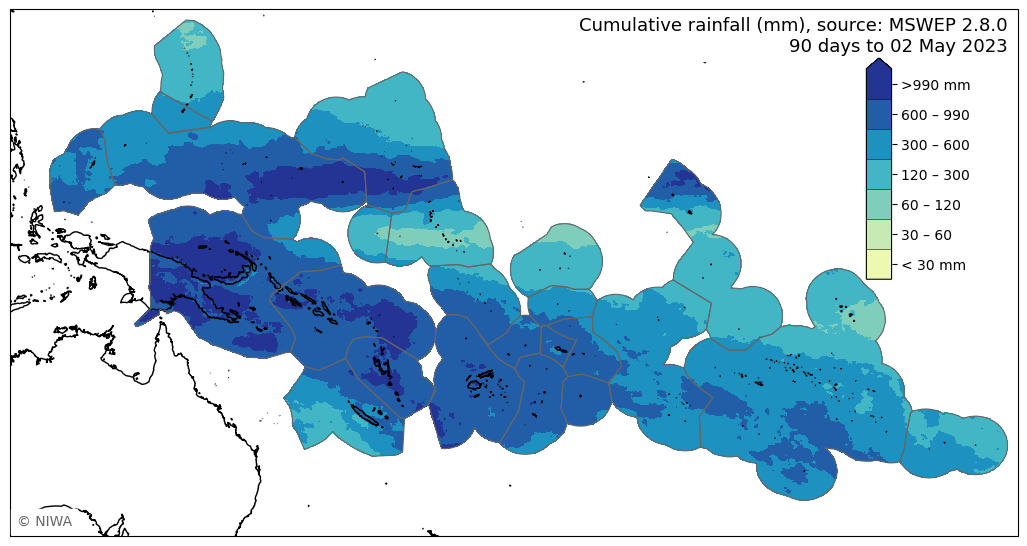

In [24]:
plot.map_precip_accum(
    dset, varname=varname, close=False, mask="EEZs", geoms=EEZs, source="MSWEP 2.8.0"
)

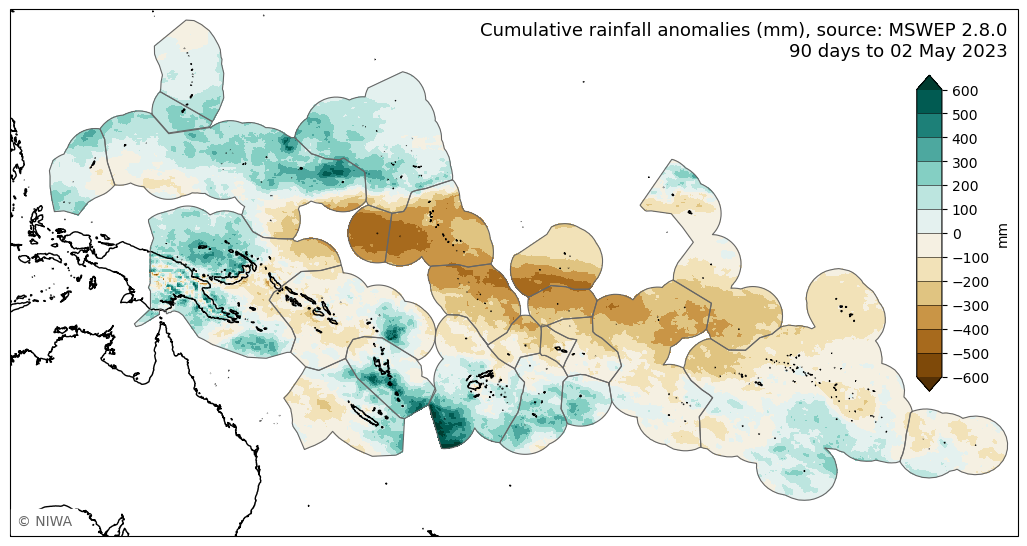

In [25]:
plot.map_precip_anoms(
    dset, varname="anoms", close=False, mask="EEZs", geoms=EEZs, source="MSWEP 2.8.0"
)

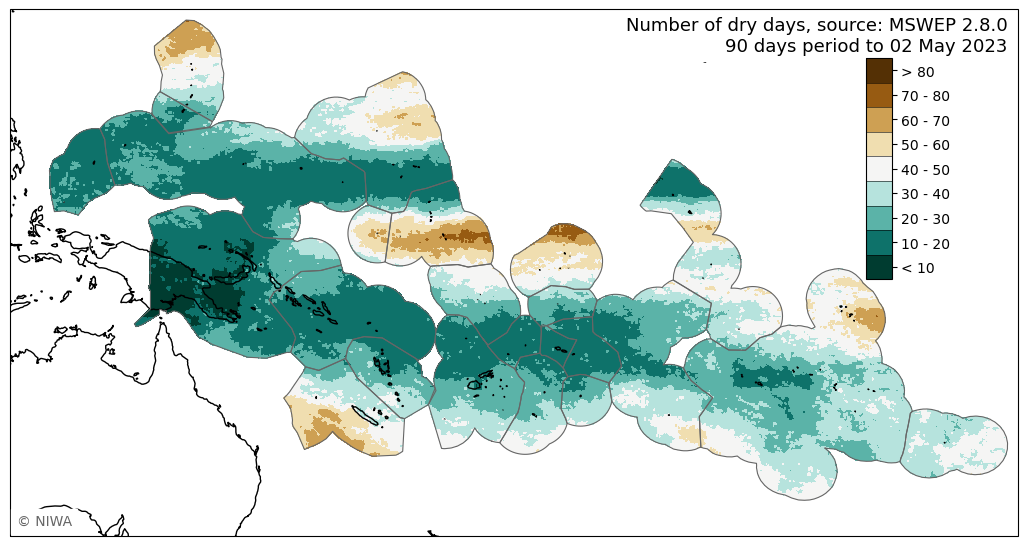

In [26]:
plot.map_dry_days_Pacific(
    dset, varname="dry_days", close=False, mask="EEZs", geoms=EEZs, source="MSWEP 2.8.0"
)

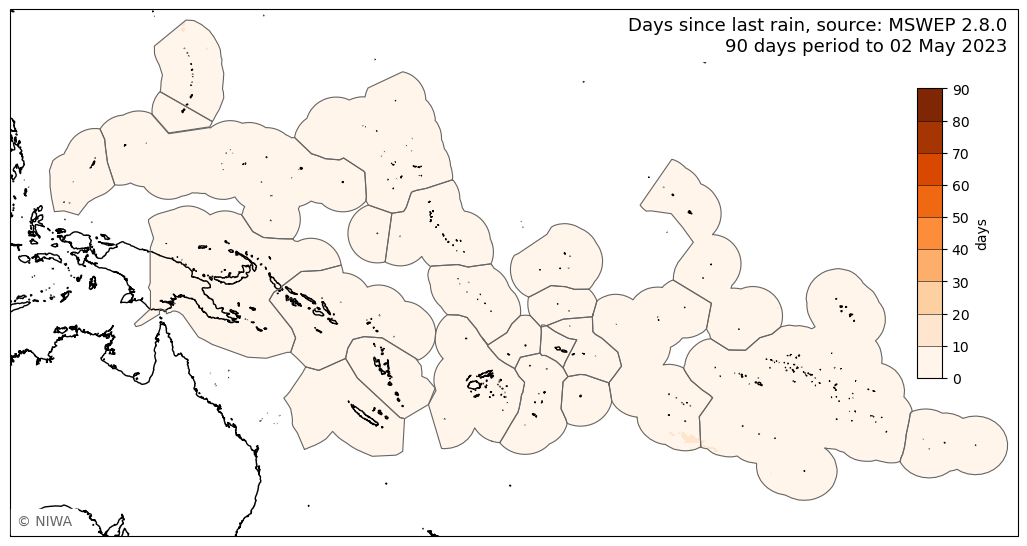

In [27]:
plot.map_days_since_rain_Pacific(
    dset,
    varname="days_since_rain",
    close=False,
    mask="EEZs",
    geoms=EEZs,
    source="MSWEP 2.8.0",
)

### Now we get the quantiles defining the 'EAR Watch' categories

In [28]:
dset.coords["quantile"]

<xarray.DataArray 'quantile' (quantile: 15)>
array([0.02  , 0.05  , 0.1   , 0.2   , 0.25  , 0.3   , 0.3333, 0.4   , 0.5   ,
       0.6   , 0.6666, 0.7   , 0.75  , 0.8   , 0.9   ])
Coordinates:
    time      datetime64[ns] 2023-05-02
    DOY       int64 ...
  * quantile  (quantile) float64 0.02 0.05 0.1 0.2 0.25 ... 0.7 0.75 0.8 0.9

In [29]:
EAR_threshs = [0.05, 0.1, 0.25, 0.9]

In [30]:
EAR_quantiles = dset[["precipitation_quantiles"]].sel(quantile=EAR_threshs)

In [31]:
def _digitize(x, bins):
    return np.digitize(x.ravel(), bins.ravel())

In [32]:
EAR_categories = xr.apply_ufunc(
    _digitize,
    dset[varname],
    EAR_quantiles[f"{varname}_quantiles"],
    input_core_dims=[[], ["quantile"]],
    vectorize=True,
    dask="parallelized",
)

In [33]:
with ProgressBar():
    EAR_categories = EAR_categories.compute()

[########################################] | 100% Completed | 29.91 s


In [141]:
def map_categories(
    dataarray,
    mask=None,
    colors_list=None,
    labels_list=None,
    geoms=None,
    fpath=None,
    extent=None,
    close=False,
    gridlines=False,
    spacing={"lon": 20, "lat": 10},
    title="", 
    title_top=False,
    cbar_xanchor=0.75, 
    cbar_yanchor=0.6
):
    # get the unique categories from the dataarray
    cats = np.unique(dataarray)
    
    cats = cats[~np.isnan(cats)]
    
    ncats = len(cats)

    if mask is not None:
        dataarray = dataarray * mask

    if colors_list is None:
        # EAR Watch colors
        colors_list = ["#F04E37", "#F99D1C", "#FFDE40", "#FFFFFF", "#33BBED"]

    if labels_list is None:
        # EAR Watch categories
        labels_list = [
            "Severely dry (< 5%)",
            "Seriously dry (< 10%)",
            "Warning (< 25%)",
            "Near or Wetter",
            "Seriously wet (> 90%)",
        ]

    if (len(colors_list) != ncats) or (len(labels_list) != ncats):
        raise ValueError(
            f"The number of categories ({ncats}) does not match the list of colors or labels"
        )
        pass
    else:
        f, ax = plt.subplots(
            figsize=(13, 8),
            subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
        )

        lims = []

        for i, cat in enumerate(cats):
            im = dataarray.where(dataarray == cat).plot(
                levels=2,
                colors=colors_list[i],
                add_colorbar=False,
                transform=ccrs.PlateCarree(),
            )

            lims.append(im)

        if geoms is not None:
            plot.add_geom(ax=ax, geoms=geoms)

        if gridlines:
            plot.make_gridlines(ax=ax, lon_step=spacing["lon"], lat_step=spacing["lat"])

        ax.coastlines("10m")

        if extent is not None:
            ax.set_extent(extent, crs=ccrs.PlateCarree())

        plot.make_dummy_colorbar(
            ax,
            lims,
            colors_list=colors_list,
            labels_list=labels_list,
            xpos=cbar_xanchor,
            ystart=cbar_yanchor,
            bbox=True,
        )

        ax.set_title("")
        
        if title_top: 
            
            ax.set_title(title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right')
            
        else: 
            
            ax.text(0.99, 0.95, title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
    
        # copyright notice 
    
        ax.text(0.0065, 0.02, u'\u00A9'+" NIWA", transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'), fontdict=dict(color='0.4'))
        
        f.patch.set_facecolor("white")

        if fpath is not None:
            if type(fpath) != pathlib.PosixPath:
                fpath = pathlib.Path(fpath)

            f.savefig(
                fpath.joinpath(
                    f"EAR_Watch_Pacific_{ndays}days_to_{last_day:%Y-%m-%d}.png"
                ),
                dpi=200,
                bbox_inches="tight",
            )

        if close:
            plt.close(f)

In [142]:
title = f"Water Stress (aligned to \"EAR\" alert levels), source MSWEP 2.8.0\n{nbdays_agg} days to {date_stop:%d %b %Y}"

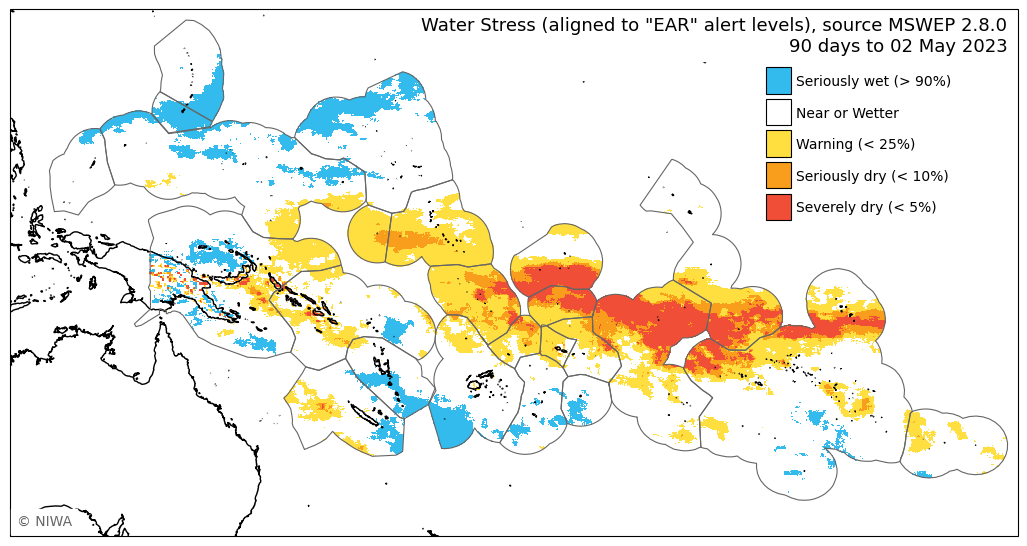

In [143]:
map_categories(
    EAR_categories,
    mask=dset['EEZs'],
    colors_list=None,
    labels_list=None,
    geoms=EEZs,
    fpath=None,
    extent=domains.domains['Water_Watch'],
    close=False,
    gridlines=False,
    spacing={"lon": 20, "lat": 10},
    title=title
)

### Now plot the USDM levels

In [37]:
USDM_threshs = [0.02, 0.05, 0.1, 0.2, 0.3]

In [38]:
USDM_quantiles = dset[["precipitation_quantiles"]].sel(quantile=USDM_threshs)

In [39]:
USDM_colors_list = ['#8a0606', '#fc0b03','#fc9003','#ffd08a','#ffeb0f','#ffffff']

In [40]:
USDM_labels = ['D4 (Exceptional Drought)', 'D3 (Extreme Drought)', 'D2 (Severe Drought)', 'D1 (Moderate Drought)', 'D0 (Abnormally Dry)', 'None']

In [41]:
USDM_categories = xr.apply_ufunc(
    _digitize,
    dset[varname],
    USDM_quantiles[f"{varname}_quantiles"],
    input_core_dims=[[], ["quantile"]],
    vectorize=True,
    dask="parallelized",
)

In [42]:
with ProgressBar():
    USDM_categories = USDM_categories.compute()

[########################################] | 100% Completed | 29.36 s


In [43]:
title = f"US Drought Monitor (USDM), source MSWEP 2.8.0\n{nbdays_agg} days to {date_stop:%d %b %Y}"

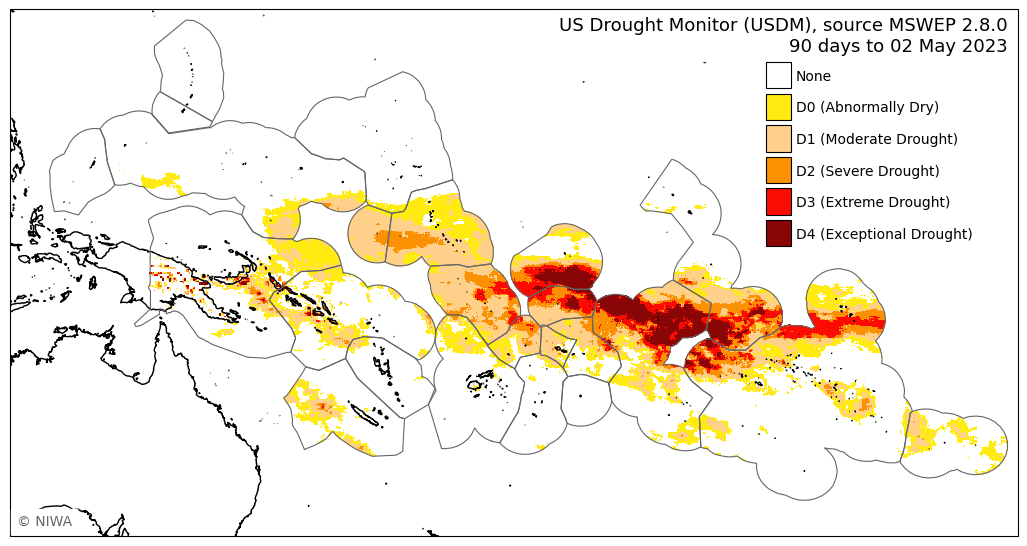

In [44]:
map_categories(
    USDM_categories,
    mask=dset['EEZs'],
    colors_list=USDM_colors_list,
    labels_list=USDM_labels,
    geoms=EEZs,
    fpath=None,
    extent=domains.domains['Water_Watch'],
    close=False,
    gridlines=False,
    spacing={"lon": 20, "lat": 10},
    title=title,
    cbar_yanchor=0.55
)

### Now only the SPI 

In [45]:
dset

<xarray.Dataset>
Dimensions:                  (lon: 1400, lat: 800, quantile: 15)
Coordinates:
    time                     datetime64[ns] 2023-05-02
  * lon                      (lon) float32 100.1 100.2 100.3 ... 239.9 240.0
  * lat                      (lat) float32 -49.95 -49.85 -49.75 ... 29.85 29.95
    DOY                      int64 ...
  * quantile                 (quantile) float64 0.02 0.05 0.1 ... 0.75 0.8 0.9
Data variables:
    precipitation            (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    anoms                    (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    precipitation_average    (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    precipitation_quantiles  (quantile, lat, lon) float64 dask.array<chunksize=(15, 50, 50), meta=np.ndarray>
    alpha                    (lat, lon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    beta                     (lat, lon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    wet_days                 (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    dry_days                 (lat, lon) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    days_since_rain          (lat, lon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    EEZs                     (lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    history:          Created on 2023-02-03 01:02
    input_data_hash:  f8421297c20bb9c4802da23128fa95e2cbd557ee870806ced8272cc...
    filename_origin:  2023033.nc
    ndays:            90
    last_day:         2023-05-02
    DOY:              122

In [57]:
SPI = MSWEP.calculate_SPI(dset[varname], dset['alpha'], dset['beta'], name='SPI')

In [58]:
SPI

<xarray.Dataset>
Dimensions:  (lon: 1400, lat: 800)
Coordinates:
    time     datetime64[ns] 2023-05-02
  * lon      (lon) float32 100.1 100.2 100.3 100.4 ... 239.7 239.8 239.9 240.0
  * lat      (lat) float32 -49.95 -49.85 -49.75 -49.65 ... 29.75 29.85 29.95
    DOY      int64 122
Data variables:
    SPI      (lat, lon) float64 -1.968 -1.85 -1.834 ... 0.41 0.4318 0.4146

In [91]:
SPI_threshs = [-2, -1.5, -1, 1, 1.5, 2]

In [92]:
SPI_categories = np.digitize(SPI['SPI'].data, SPI_threshs)

In [93]:
SPI_categories.shape

(800, 1400)

In [104]:
SPI['SPI_categories'] = (('lat','lon'), SPI_categories)

In [111]:
SPI['SPI_categories'] = SPI['SPI_categories'].where(SPI['SPI_categories'] != 3)

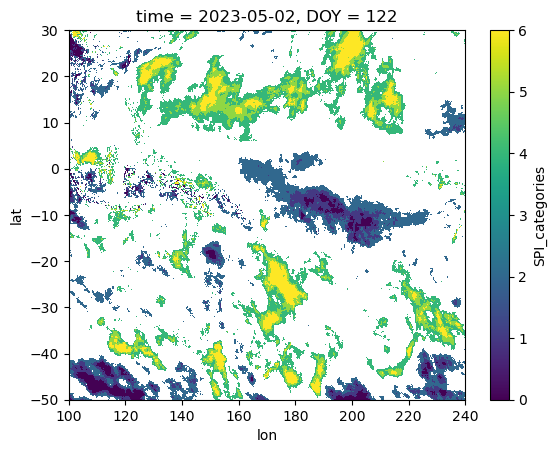

In [117]:
SPI['SPI_categories'].plot()

In [137]:
SPI_colors_list = ['#F04E37', '#F99D1C', '#FFDE40', '#96ceff', '#4553bf', '#09146b']

In [138]:
SPI_labels = ['extremely dry','severely dry','moderately dry', 'moderately wet','severely wet','extremely wet']

In [147]:
title = f"Standardized Precipitation Index (SPI), source MSWEP 2.8.0\n{nbdays_agg} days to {date_stop:%d %b %Y}"

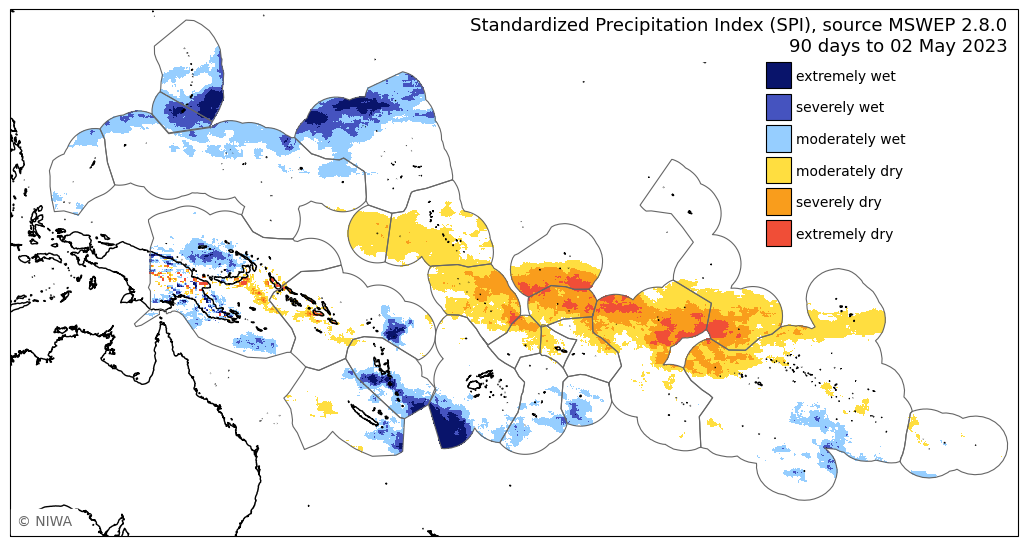

In [148]:
map_categories(
    SPI['SPI_categories'],
    mask=dset['EEZs'],
    colors_list=SPI_colors_list,
    labels_list=SPI_labels,
    geoms=EEZs,
    fpath=None,
    extent=domains.domains['Water_Watch'],
    close=False,
    gridlines=False,
    spacing={"lon": 20, "lat": 10},
    title=title,
    cbar_yanchor=0.55
)